# Setup

In [1]:
import Pkg
using Revise
using JLD

In [2]:
using SNNT

In [3]:
using PyCall

In [4]:
using Plots

In [5]:
using ColorSchemes

In [6]:
#plotlyjs()
pyplot()

Plots.PyPlotBackend()

In [7]:
py"""
import numpy as np
import polytope as pc
from polytope.solvers import lpsolve
def cheby_ball(poly1):
    #logger.debug('cheby ball')
    if (poly1._chebXc is not None) and (poly1._chebR is not None):
        # In case chebyshev ball already calculated and stored
        return poly1._chebR, poly1._chebXc
    if isinstance(poly1, pc.Region):
        maxr = 0
        maxx = None
        for poly in poly1.list_poly:
            rc, xc = cheby_ball(poly)
            if rc > maxr:
                maxr = rc
                maxx = xc
        poly1._chebXc = maxx
        poly1._chebR = maxr
        return maxr, maxx
    if pc.is_empty(poly1):
        return 0, None
    # `poly1` is nonempty
    r = 0
    xc = None
    A = poly1.A
    c = np.negative(np.r_[np.zeros(np.shape(A)[1]), 1])
    norm2 = np.sqrt(np.sum(A * A, axis=1))
    G = np.c_[A, norm2]
    h = poly1.b
    sol = lpsolve(c, G, h)
    #return sol
    if sol['status'] == 0 or (sol['status'] == 4 and pc.is_inside(poly1,sol['x'][0:-1])):
        r = sol['x'][-1]
        if r < 0:
            return 0, None
        xc = sol['x'][0:-1]
    else:
        # Polytope is empty
        poly1 = pc.Polytope(fulldim=False)
        return 0, None
    poly1._chebXc = np.array(xc)
    poly1._chebR = np.double(r)
    return poly1._chebR, poly1._chebXc
"""
cheby_ball = py"cheby_ball"

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


PyObject <function cheby_ball at 0x7f51af53cdc0>

In [8]:
py"""
import numpy as np
import polytope as pc
def get_extremes(poly1):
    import matplotlib as mpl
    V = pc.extreme(poly1)
    rc, xc = cheby_ball(poly1)
    x = V[:, 1] - xc[1]
    y = V[:, 0] - xc[0]
    mult = np.sqrt(x**2 + y**2)
    x = x / mult
    angle = np.arccos(x)
    corr = np.ones(y.size) - 2 * (y < 0)
    angle = angle * corr
    ind = np.argsort(angle)
    return V[ind, :]
"""
get_extremes = py"get_extremes"

PyObject <function get_extremes at 0x7f51af53cd30>

In [9]:
function intersect(pc, p1, p2)
    iA = [p1.A; p2.A]
    ib = append!(p1.b,p2.b)

    return pc.Polytope(iA, ib)
end

function bound_fun(rPos)
    # rPos >= rVel^2 / (2*A)
    # =>
    #rVel = 
    return -sqrt(rPos*2*100)
end

function draw_polygons(ce_list;reuse=false,color=:yellow,boundsfun=true,dims=[0,1])
    pc = pyimport("polytope")
    xpts = range(1,100, length=500)
    eps=1.0
    if !reuse
        plot(grid=false)
    end
    for (i, star) in enumerate(ce_list)
        orig_poly = pc.Polytope(star.constraint_matrix,star.constraint_bias)
        bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds)))
        orig_poly = intersect(pc,orig_poly,bounds)
        #cheby_ball(orig_poly)
        print(orig_poly.A)
        if size(star.constraint_matrix)[2]<=2
            proj_poly=orig_poly
        else
            proj_poly = pc.polytope.projection(orig_poly,dims)
        end
        print(proj_poly.A)
        #bounds = pc.box2poly([[star.bounds[dims[1]+1][1],star.bounds[dims[1]+1][2]],[star.bounds[dims[2]+1][1],star.bounds[dims[2]+1][2]]])
        p = proj_poly
        drawn = false
        try
            # Manually compute cheby ball because other thing is broken
            cheby_ball(p)
            if pc.is_fulldim(p)
                points = get_extremes(p)
                print(points)
                plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = plot_color(color, 0.5))
                drawn = true
            else
                #plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = plot_color(:grey, 0.3))
                println("Empty")
            end
        catch e
            println("Failed")
        end
        if !drawn
            plot!(Shape(
            [star.bounds[dims[1]+1][1],star.bounds[dims[1]+1][1],star.bounds[dims[1]+1][2]+eps,star.bounds[dims[1]+1][2]+eps,star.bounds[dims[1]+1][1]],
            [star.bounds[dims[2]+1][1],star.bounds[dims[2]+1][2]+eps,star.bounds[dims[2]+1][2]eps,star.bounds[dims[2]+1][1],star.bounds[dims[2]+1][1]]),
            label="", fillcolor=plot_color(:grey, 0.3))
        end
    end
    if boundsfun
        return plot!(xpts,bound_fun.(xpts),label="Bound Function",linecolor = plot_color(:red, 1.0))
    else
        return plot!()
    end
end

draw_polygons (generic function with 1 method)

In [10]:
function get_polytope_list(star_list)
    pc = pyimport("polytope")
    polytope_list = []
    for star in filter(x->x.certain,star_list)
        orig_poly = pc.Polytope(star.constraint_matrix,star.constraint_bias)
        bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds)))
        orig_poly = intersect(pc,orig_poly,bounds)
        cheby_ball(orig_poly)
        if pc.is_fulldim(orig_poly)
            push!(polytope_list,orig_poly)
        else
            push!(polytope_list,bounds)
        end
    end
    return polytope_list
end
py"""
import pickle
def store_polys(name,polys):
    with open(name,"wb") as f:
        pickle.dump(polys,f)
"""
store_polys = py"store_polys"

PyObject <function store_polys at 0x7f51ae9009d0>

In [11]:
min_x1 = -400
max_x1 = 400
min_x2 = -200
max_x2 = 400

400

In [21]:
in_legend = []
unsafe_legend=false
unsafe_legend_to=false
function plot_zeppelin(star,c,w,i)
    pc = pyimport("polytope")
    if c < star.bounds[3][1] || c > star.bounds[3][2] || w < star.bounds[4][1] || w > star.bounds[4][2]
        return
    end
    if star.certain
        print("+")
    else
        print("-")
    end
    A = star.constraint_matrix
    b = star.constraint_bias

    pc = pyimport("polytope")
    orig_poly = pc.Polytope(A[:,[1,2]],b-w*A[:,4]-c*A[:,3])
    bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds[[1,2]])))
    p = intersect(pc,orig_poly,bounds)
    cheby_ball(p)
    points=[]
    try
        if pc.is_fulldim(p)
            points = get_extremes(p)
        else
            points = get_extremes(bounds)
        end
    catch
        points = get_extremes(bounds)
    end
    in_legend[i]=true
    if star.certain
        if !unsafe_legend
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="Unsafe (certain)",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
            global unsafe_legend=true
        else
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
        end
    else
        if !unsafe_legend_to
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="Unsafe (uncertain)",fillcolor = :gold,linecolor=plot_color(:white, 0.0))
            global unsafe_legend_to=true
        else
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="",fillcolor = :gold,linecolor=plot_color(:white, 0.0))
        end
    end
end

plot_zeppelin (generic function with 1 method)

In [16]:
TIME_STEP = 0.5

MIN_WIND_SPEED = 1.0
MAX_WIND_SPEED = 30 # m/s in ~ 100 km/h
MAX_TURBULENCE = 15 # m/s in ~ 54 km/h
MAX_VELOCITY = 20 # m/s in ~ 72 km/h
function x1_min(x2, c, w)
        return -(TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE) + ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - (x2 - TIME_STEP * (MAX_TURBULENCE + MAX_VELOCITY+w))) + c) )
end

function x1_max(x2, c, w)
    return TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE) + ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - (x2 - TIME_STEP * (MAX_TURBULENCE + MAX_VELOCITY+w))) + c)
end
    
function x2_max(c,w)
    return c + w / (MAX_VELOCITY - MAX_TURBULENCE) * c + TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE + w)
end
    
function x2_min(c)
    return -c - TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE)
end

x2_min (generic function with 1 method)

In [28]:
legend_labels=false
function plot_all_zeppelin(stars,c,w;plotnew=true)
    x2_1 = x2_min(c)
    x2_2 = x2_max(c,w)
    
    x1_11 = x1_min(x2_1,c,w)
    x1_12 = x1_max(x2_1,c,w)
    x1_21 = x1_min(x2_2,c,w)
    x1_22 = x1_max(x2_2,c,w)
    
    if plotnew
        plot()
    end
    
    for (i,star) in enumerate(stars)
        plot_zeppelin(star,c,w,i)
    end
    
    polygon = [(x1_11,x2_1),(x1_12,x2_1),(x1_22,x2_2),(x1_21,x2_2),(x1_11,x2_1)]
    if !legend_labels
        plot!(map(x->x[1],polygon),map(x->x[2],polygon),linecolor=:royalblue3,label="Outer State Space Bound",margin=1Plots.mm)
    else
        plot!(map(x->x[1],polygon),map(x->x[2],polygon),linecolor=:royalblue3,label="",margin=1Plots.mm)
    end
    
    
    xtop = c + w / (MAX_VELOCITY - MAX_TURBULENCE) * c
    #min_x2 = x2_1-20
    #max_x2 = min(x2_2+20,400)
    x2 = collect(-c:1.:xtop)
    x1 = map( x -> (- ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - x) + c)), x2)
    if !legend_labels
        plot!(x1,x2, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="Inner State Space Bound")
        
    else
        plot!(x1,x2, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="")
    end
    plot!(Shape([0,-c,c,0],[xtop,c,c,xtop]),linecolor=:darkslategray3,fillcolor=:darkslategray3,label="")
    x22 = collect(-c:1.:xtop)
    x21 = map( x -> ( ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - x) + c)), x2)
    plot!(x21,x22, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="")
    plot!([x1[1],x21[1]],[x2[1],x22[1]],linecolor=:darkslategray3,label="")
    if !legend_labels
        plot!(Shape(
                    [-c,-c,c,c,-c],
                    [c,-c,-c,c,c]),
                    label="Obstacle", fillcolor=:orange,linecolor=plot_color(:white, 0.0), xlims=(min_x1,max_x1),ylims=(min_x2,max_x2))
    else
        plot!(Shape(
                    [-c,-c,c,c,-c],
                    [c,-c,-c,c,c]),
                    label="", fillcolor=:orange,linecolor=plot_color(:white, 0.0), xlims=(min_x1,max_x1),ylims=(min_x2,max_x2))
    end
    global legend_labels=true
    return plot!()
end
    

plot_all_zeppelin (generic function with 1 method)

# Analysis of `zeppelin-small2-1400000`

In [15]:
# ~ 54 hours
zeppelin_small2_data = load("zeppelin-small2-1400000/approx1-fixed.jld")
print(zeppelin_small2_data["args"])
zeppelin_small2_results = zeppelin_small2_data["result"]
zeppelin_small2_stars = zeppelin_small2_results.stars

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/zeppelin/zeppelin-small2-1400000/approx1-fixed.jld", "mapping" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/fixed", "network" => "test/networks/zeppelin-1400000-8-8.onnx", "formula" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/formula", "smt" => "Z3", "smtfilter-timeout" => 500000)

2569-element Vector{SNNT.VerifierInterface.Star}:
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5353276 0.41824415 0.6293562 0.37736842; -0.00557283 -0.84394723 -0.020848142 -0.53599185], Float32[-0.0, 12.374369, -7.2877088, -3.505951, -3.37653, -5.8898563, -3.4374573, -3.750208, 0.16231672, 0.1554425, -0.13414817, -0.023391763, -0.301299, -0.0892771, 0.34835938, 0.075353496, 0.060491025, -3.3782852], Float32[2.9802322f-8 2.9802322f-8 5.9604645f-8 2.9802322f-8; -0.04774768 0.102635644 0.048629563 0.1441748], Float32[1.0, -0.09388359], [(19.718068632440435, 37.08628764982535), (-1.0336245143064957, 5.9040855517331465), (12.865032151239433, 21.46479606628418), (5.0, 8.469886353205103)], (Float32[27.402313, -0.75039613, 20.0539, 6.4194746], Float32[1.0, 0.42144075]), true)
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5867489 -0.057223648 0.8061738 -0.050348196; 

In [16]:
store_polys("training/zeppelin-small2-polytopes-fixed.pickle",get_polytope_list(zeppelin_small2_stars))

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you

### Certain Counter-Example polytopes
SMT Solver produced a concrete counter-example

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85902e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.64503e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.48167e-43): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.51143e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.40517e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.9633e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.49488e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.0961e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: Li

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.89918e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47057e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.71571e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47225e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.54396e-55): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.14291e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.34499e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.98662e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.80284e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.72278e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.56146e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.65805e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.00453e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.77917e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.42175e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.06109e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

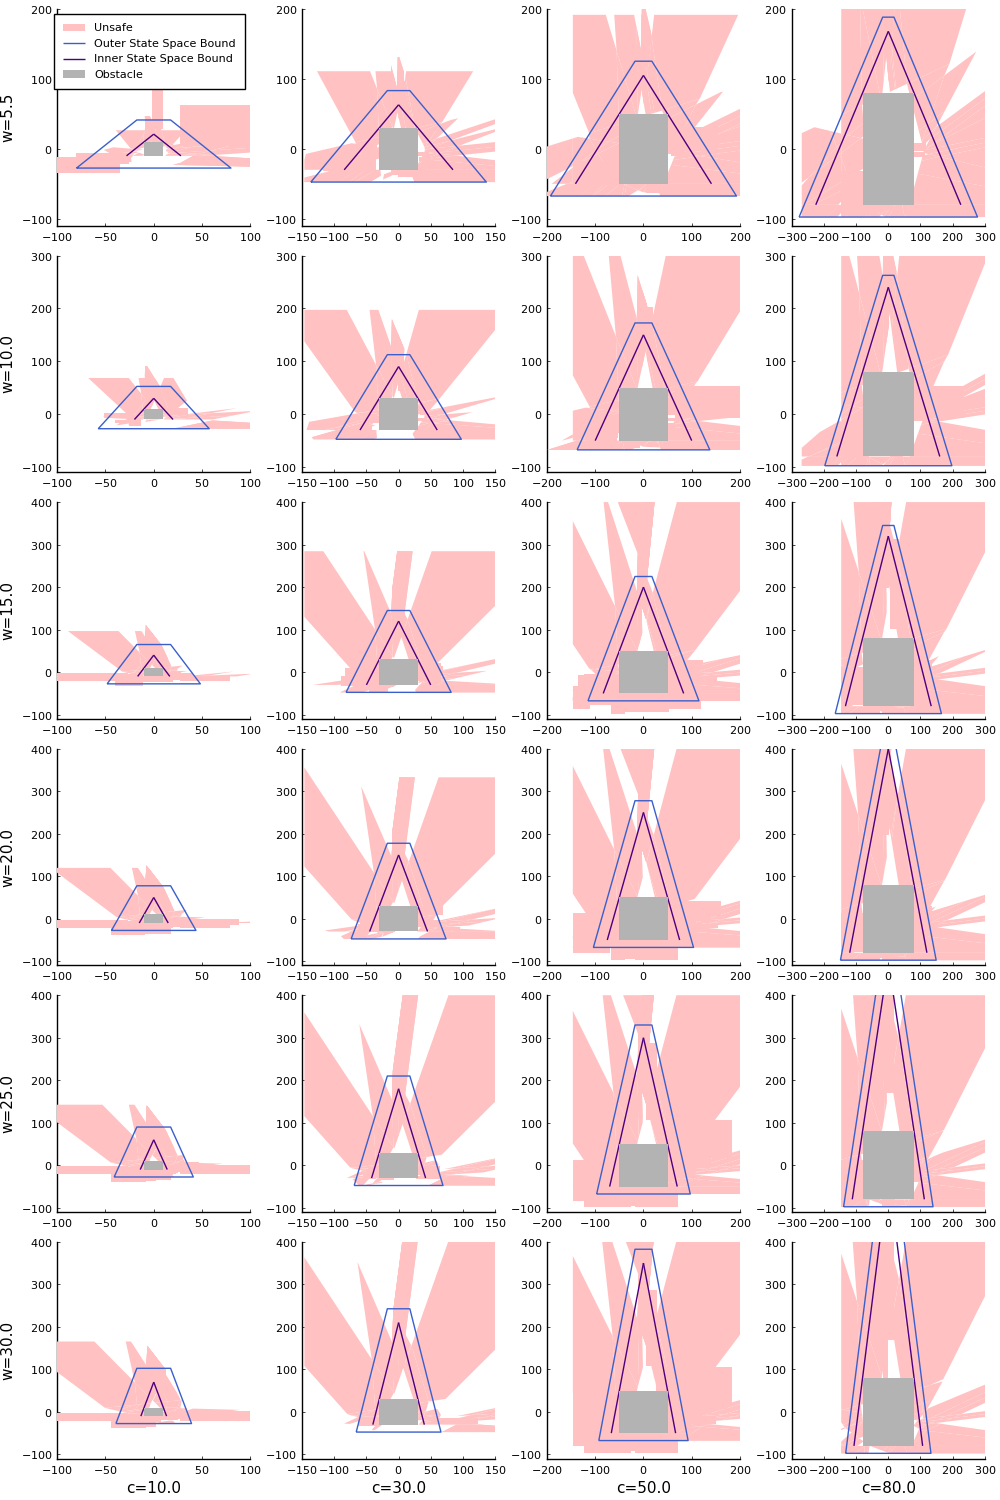

In [19]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [20]:
savefig(fig,"zeppelin-small2-certain.eps")

### Certain Counter-Example polytopes
SMT Solver could not rule out concrete counter-example

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.72173e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.25856e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.43783e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.08064e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.74102e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

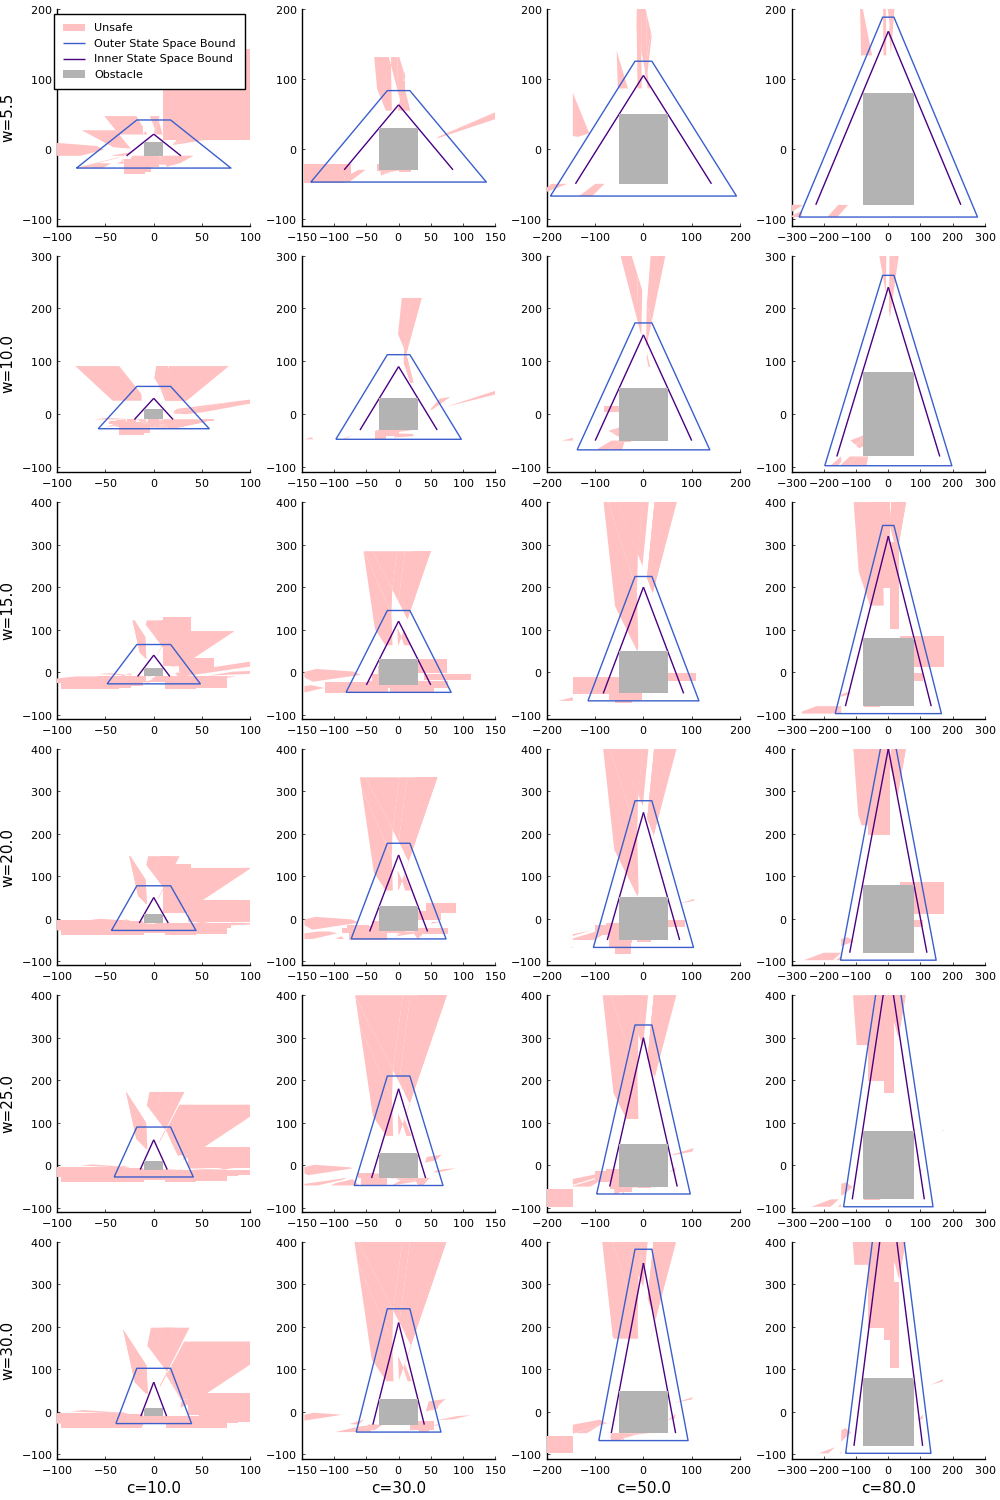

In [21]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->!x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->!x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [22]:
savefig(fig,"zeppelin-small2-uncertain.eps")

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85902e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.87685e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.21247e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.17725e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.97951e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.50043e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.85906e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.74115e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.56995e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47057e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.71571e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47225e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.03687e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.8846e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.77435e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.05038e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.54396e-55): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.90672e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.95881e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.75734e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.19593e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.62457e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.33106e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.60798e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.54623e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

+++++++++++++++++++++++-+++-+++-++++++-+++++-+-+++++++++++++-++++++-+++++++-++++++---+++------+----------++-+++------------------------++++++++-+++++-++++--+--+-----++----+++--+--+--+++++++---+++++++++++++++++++++++++++++++-++++++++++++++++++++++++++-++++-++++++++-+++-+---++++++++-+++-++-+++++-++++--+++++++--+-----++--++-+-++++++++++++++++++++++++++++++++++++++++++++++-++++-++++++++-+++-++-++++++++++++++++++++++++++-+++--+--++---++-+-+-++++++++++++++++++++++++++++++++++++++++++++++-+++-+++++++++-++-+++++++++++++++++++++++++-++++-++--+-+-+--+-+--++++++++++-+++++++++++++++++++++++++-++++-+++++++++++++--+++++-+++++++++++++++++++++++++--++-------------------------+++----+-+-------+---+-------+++-+-+------+++++++--++-++-++++-------++-----------++------++---++---+-++-++++++++++++-++++++++++++++++++++++++++++++-+++++++++++++++++++++++++++++-++++--+--+---+++--------++++---+-++++-+---++++++--+++++++++++++++++++++++++++++++++++++++++-++++++---++++++++++-+++++++++-++++++++++-++++++++++++++++++--+

, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.87091e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.37679e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.40896e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.78844e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

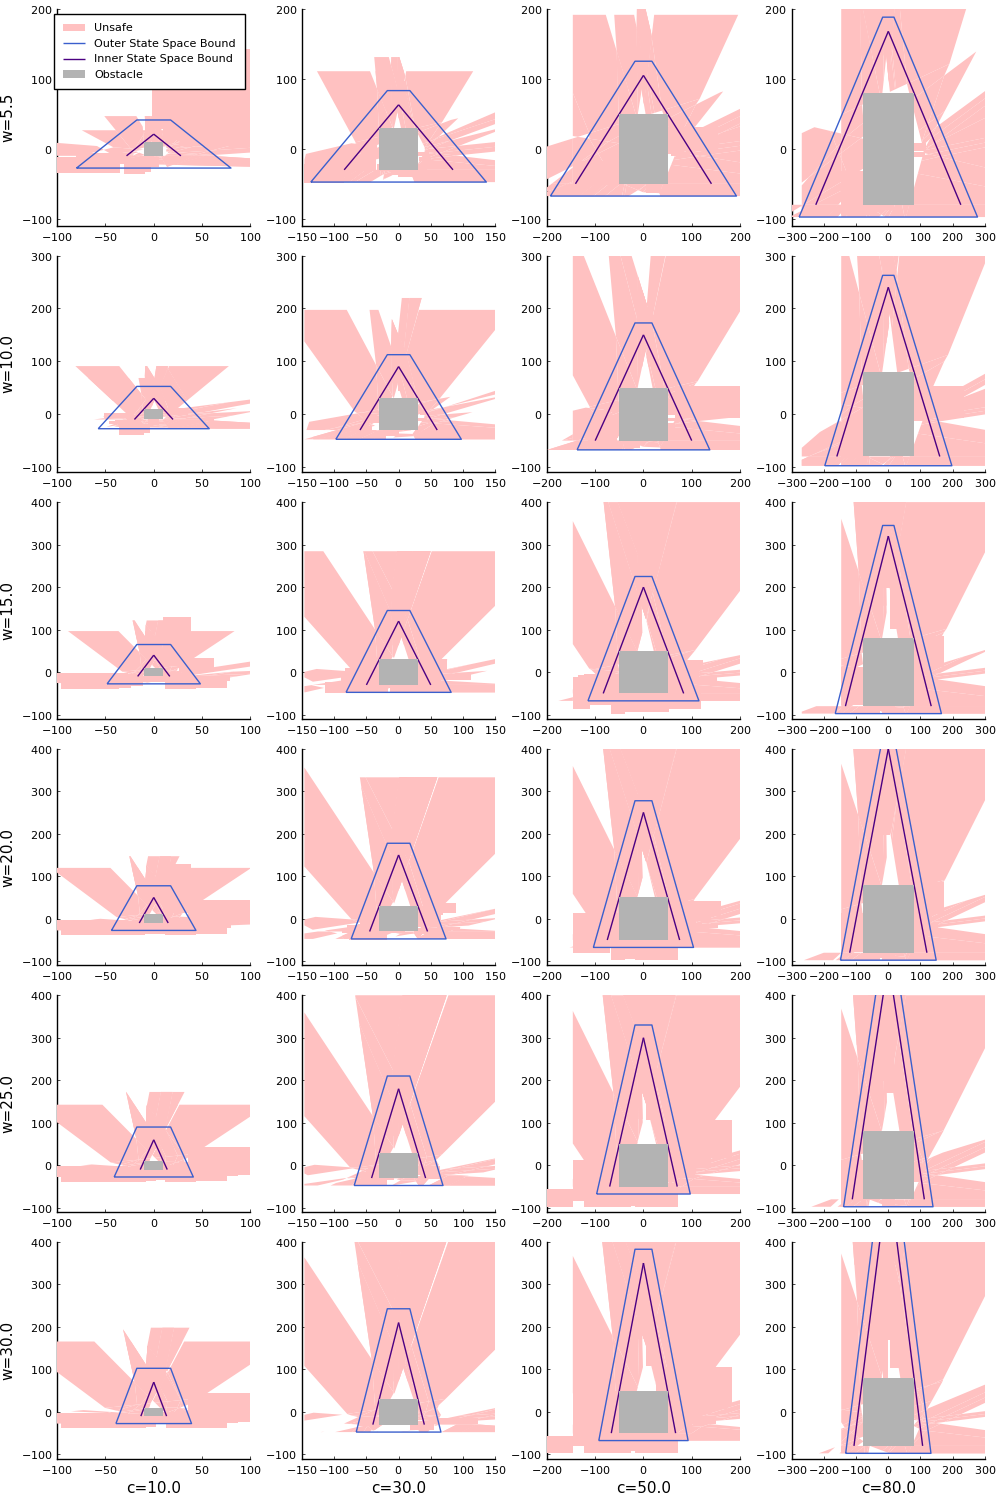

In [23]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in zeppelin_small2_stars)
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(zeppelin_small2_stars,c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [24]:
savefig(fig,"zeppelin-small2-all.eps")

## Analyis of NNEnum Simple precise run of `zeppelin-small2-1400000`

In [25]:
# ~ 34 hours
zeppelin_small2_data_precise = load("zeppelin-small2-1400000/zeppelin-small2-precise-NNEnumSimple.jld")
print(zeppelin_small2_data_precise["args"])
zeppelin_small2_precise_results = zeppelin_small2_data_precise["result"]
zeppelin_small2_precise_stars = zeppelin_small2_precise_results.stars

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "zeppelin-small2-precise.jld", "mapping" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/mapping", "verifier" => "NNEnumSimple", "rigorous" => false, "fixed" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/fixed", "network" => "test/networks/zeppelin-1400000-8-8.onnx", "formula" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/formula-precise", "smt" => "Z3", "smtfilter-timeout" => 50000)

920-element Vector{SNNT.VerifierInterface.Star}:
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5353276 0.41824415 0.6293562 0.37736842; -0.00557283 -0.84394723 -0.020848142 -0.53599185], Float32[-0.0, 12.374369, -7.2877088, -3.505951, -3.37653, -5.8898563, -3.4374573, -3.750208, 0.16231672, 0.1554425, -0.13414817, -0.023391763, -0.301299, -0.0892771, 0.34835938, 0.075353496, 0.060491025, -3.3782852], Float32[2.9802322f-8 2.9802322f-8 5.9604645f-8 2.9802322f-8; -0.04774768 0.102635644 0.048629563 0.1441748], Float32[1.0, -0.09388359], [(19.718068632440577, 37.08628764982515), (-1.033624514306382, 5.904085551733033), (12.86503215123954, 21.46479606628418), (5.0, 8.46988635320497)], (Float32[27.402313, -0.75039613, 20.0539, 6.4194746], Float32[1.0, 0.42144075]), false)
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5867489 -0.057223648 0.8061738 -0.050348196; -0.5

In [26]:
store_polys("training/zeppelin-small2-polytopes-precise-simple.pickle",get_polytope_list(zeppelin_small2_precise_stars))

### Certain

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

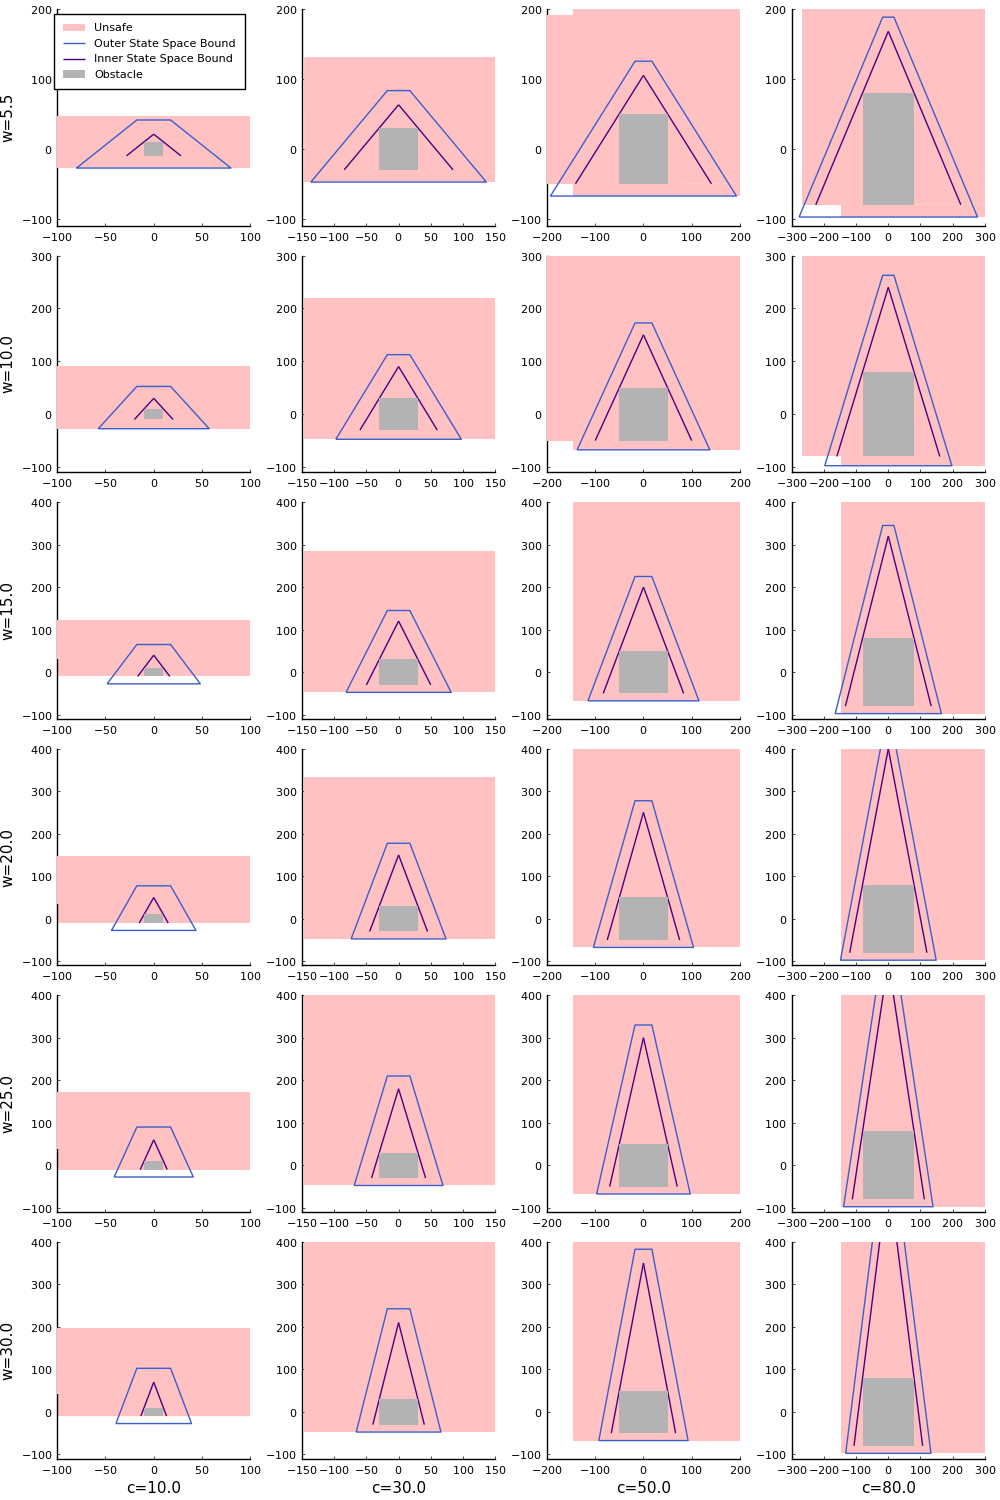

In [27]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->x.certain,zeppelin_small2_precise_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->x.certain,zeppelin_small2_precise_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

### Uncertain

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.34828e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: O

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.09011e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.96812e-42): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.07747e-42): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.14668e-41): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.9446e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.14865e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.31365e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.89673e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.30624e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.67216e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.3389e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.51669e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

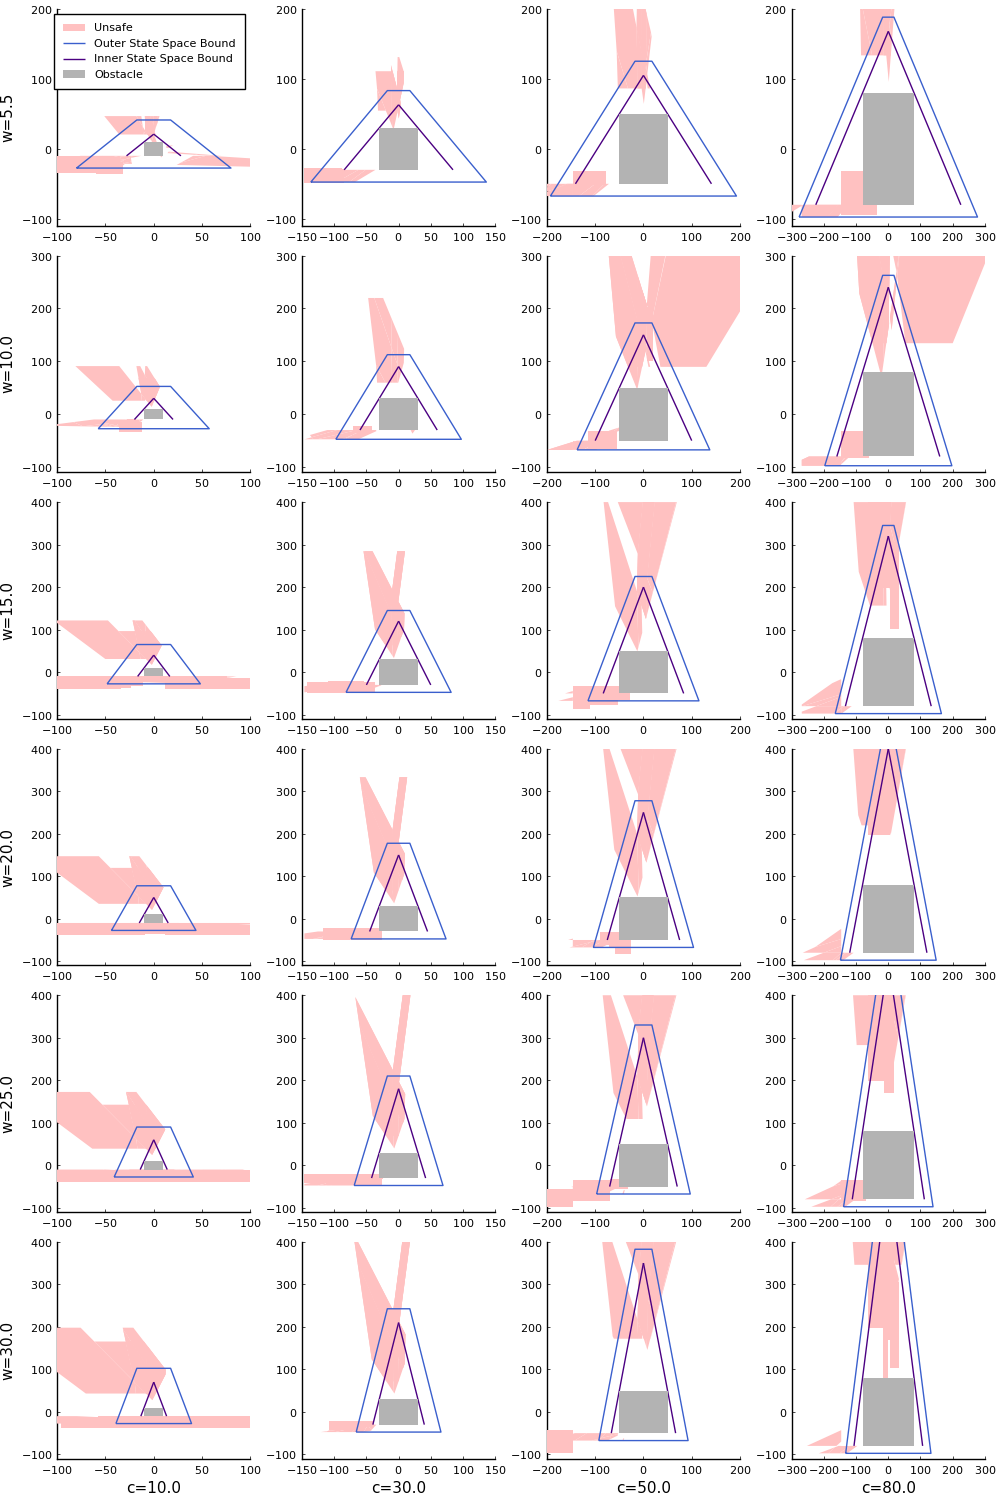

In [28]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->!x.certain,zeppelin_small2_precise_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->!x.certain,zeppelin_small2_precise_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

## Analysis of `zeppelin-small2-1400000-retrain-1000000-0.5`

In [16]:
# ~ 34 hours
zeppelin_small2_data = load("zeppelin-small2-1400000-retrain-1000000-0.5/approx1.jld")
print(zeppelin_small2_data["args"])
zeppelin_small2_results = zeppelin_small2_data["result"]
zeppelin_small2_stars = zeppelin_small2_results.stars

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/zeppelin/zeppelin-small2-1400000-retrain-1000000-0.5/approx1.jld", "mapping" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/mapping", "verifier" => "NNEnum", "rigorous" => true, "fixed" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/fixed", "network" => "test/networks/zeppelin-1400000-retrain-1000000-0.5-8-8.onnx", "formula" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/formula", "smt" => "Z3", "smtfilter-timeout" => 500000)

1878-element Vector{SNNT.VerifierInterface.Star}:
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; 0.022668628 -0.9404482 -0.13770975 -0.30996653; -0.34558278 0.45872617 0.44229954 0.6888497], Float32[-0.0, 12.374369, -7.2877088, -3.505951, -3.37653, -5.8898563, -3.4374573, -3.750208, -0.06576911, 0.2139605, 0.059787415, -0.3723934, 0.07442469, 0.08003204, -0.7700824, 0.19609705, -0.091031134, -3.7073858, -6.021048], Float32[0.0 -2.9802322f-8 -2.9802322f-8 -2.9802322f-8; 5.9604645f-8 5.9604645f-8 5.9604645f-8 5.9604645f-8], Float32[1.0, -1.0], [(45.236459411655744, 400.0), (-0.7019883037556838, 52.68941822270949), (10.0, 21.46479606628418), (5.0, 9.095212936401367)], (Float32[400.0, 7.4433985, 21.463886, 9.094303], Float32[1.0, -1.0]), true)
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.3455824 0.4587263 0.44229966 0.68884975; -0.3455824 0.4587263 0.44229966 0.68884

In [17]:
store_polys("training/zeppelin-1400000-retrain-1000000-0.5-polytopes.pickle",get_polytope_list(zeppelin_small2_stars))

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.83115e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

### Certain Counter-Example polytopes
SMT Solver produced a concrete counter-example

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.2608e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.50073e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.63673e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.23939e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.00197e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.65636e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.79836e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.70543e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.30248e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.05535e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.00286e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.01178e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.46264e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.37082e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.77419e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.12425e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.70701e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.27078e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.53603e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.61329e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

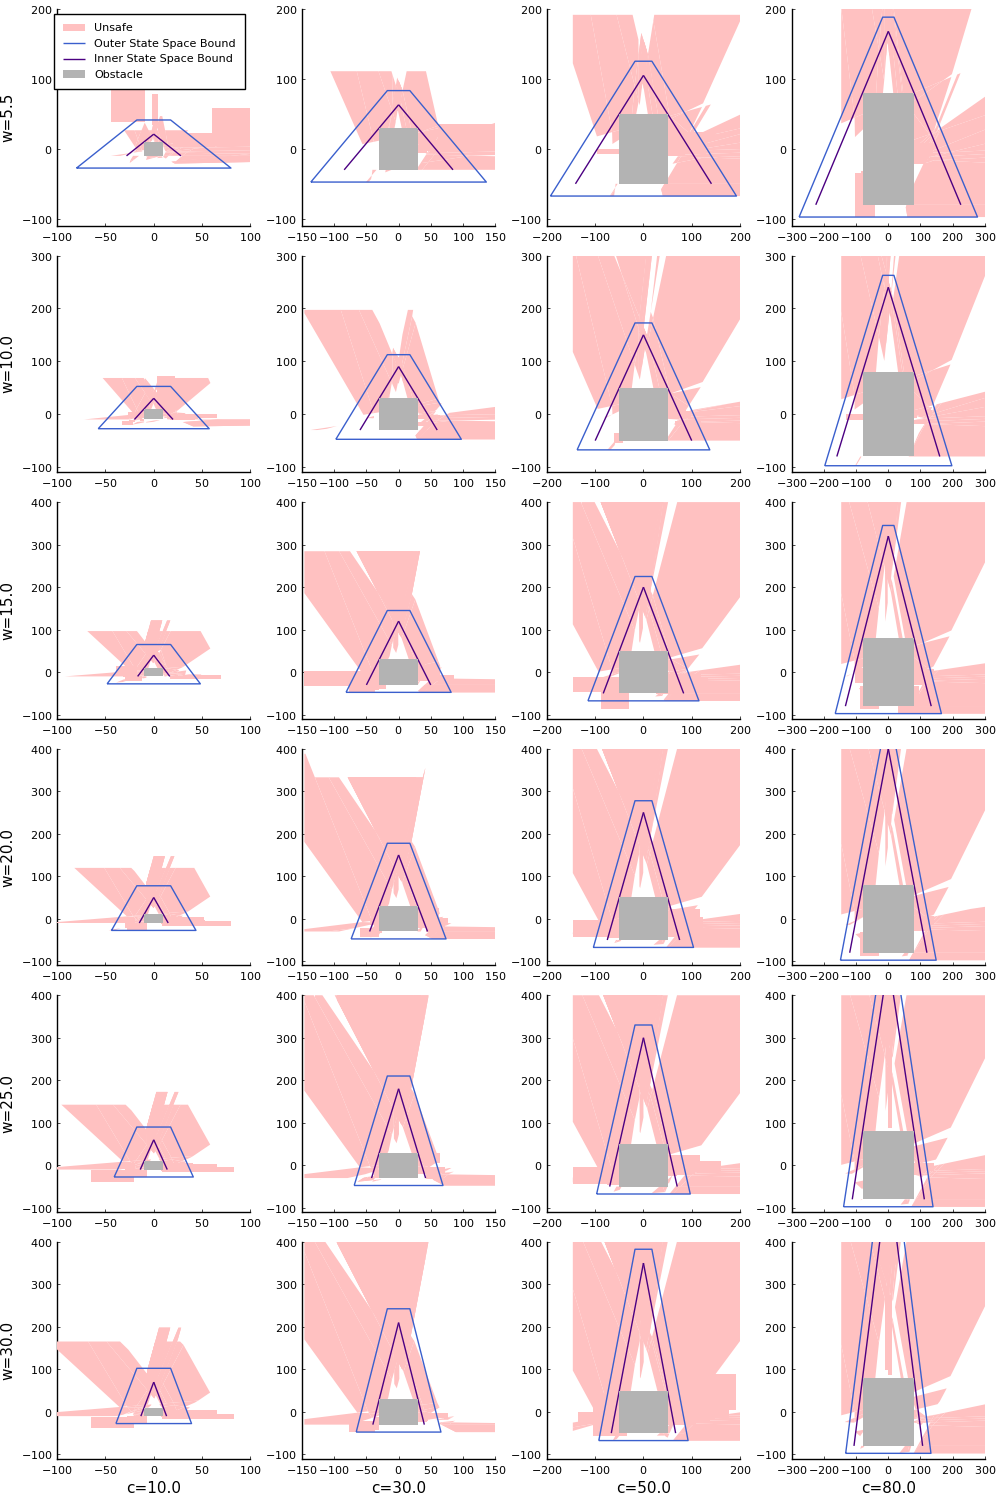

In [18]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [19]:
savefig(fig,"zeppelin-small2-1400000-retrain-1000000-0.5-certain.eps")

### Certain Counter-Example polytopes
SMT Solver could not rule out concrete counter-example

In [24]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in filter(x->!x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->!x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

-

LoadError: UndefVarError: points not defined

In [21]:
savefig(fig,"zeppelin-small2-1400000-retrain-1000000-0.5-uncertain.eps")

## Precise run

In [18]:
# INCOMPLETE!
zeppelin_small2_data = load("zeppelin-small2-1400000/approx1-precise.jld")

Dict{String, Any} with 2 entries:
  "args"   => Dict{String, Any}("approx"=>1, "linear"=>false, "output"=>"experi…
  "result" => OlnnvResult(Unsafe, Any[SmtFilterMeta(4, 4), SmtFilterMeta(4, 4),…

In [19]:
print(zeppelin_small2_data["args"])
zeppelin_small2_results = zeppelin_small2_data["result"]
zeppelin_small2_stars = zeppelin_small2_results.stars

Dict{String, Any}("approx" => 1, "linear" => false, "output" => "experiments/zeppelin/zeppelin-small2-1400000/approx1-precise.jld", "mapping" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/mapping", "verifier" => "NNEnum", "rigorous" => false, "fixed" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/fixed", "network" => "test/networks/zeppelin-1400000-8-8.onnx", "formula" => "test/parsing/examples/zeppelinAvoidanceSmallStateSpace/formula-precise", "smt" => "Z3", "smtfilter-timeout" => 125000)

2985-element Vector{SNNT.VerifierInterface.Star}:
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5353276 0.41824415 0.6293562 0.37736842; -0.00557283 -0.84394723 -0.020848142 -0.53599185], Float32[-0.0, 12.374369, -7.2877088, -3.505951, -3.37653, -5.8898563, -3.4374573, -3.750208, 0.16231672, 0.1554425, -0.13414817, -0.023391763, -0.301299, -0.0892771, 0.34835938, 0.075353496, 0.060491025, -3.3782852], Float32[2.9802322f-8 2.9802322f-8 5.9604645f-8 2.9802322f-8; -0.04774768 0.102635644 0.048629563 0.1441748], Float32[1.0, -0.09388359], [(19.718068632440435, 37.08628764982535), (-1.0336245143064957, 5.9040855517331465), (12.865032151239433, 21.46479606628418), (5.0, 8.469886353205103)], (Float32[27.402313, -0.75039613, 20.0539, 6.4194746], Float32[1.0, 0.42144075]), false)
 SNNT.VerifierInterface.Star(Float32[0.0 -0.70710677 -0.70710677 0.0; 0.0 -0.70710677 -0.70710677 0.0; … ; -0.5867489 -0.057223648 0.8061738 -0.050348196;

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10452e-41): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.88582e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.3611e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.17071e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.67726e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.41469e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.46309e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.1621e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.62884e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

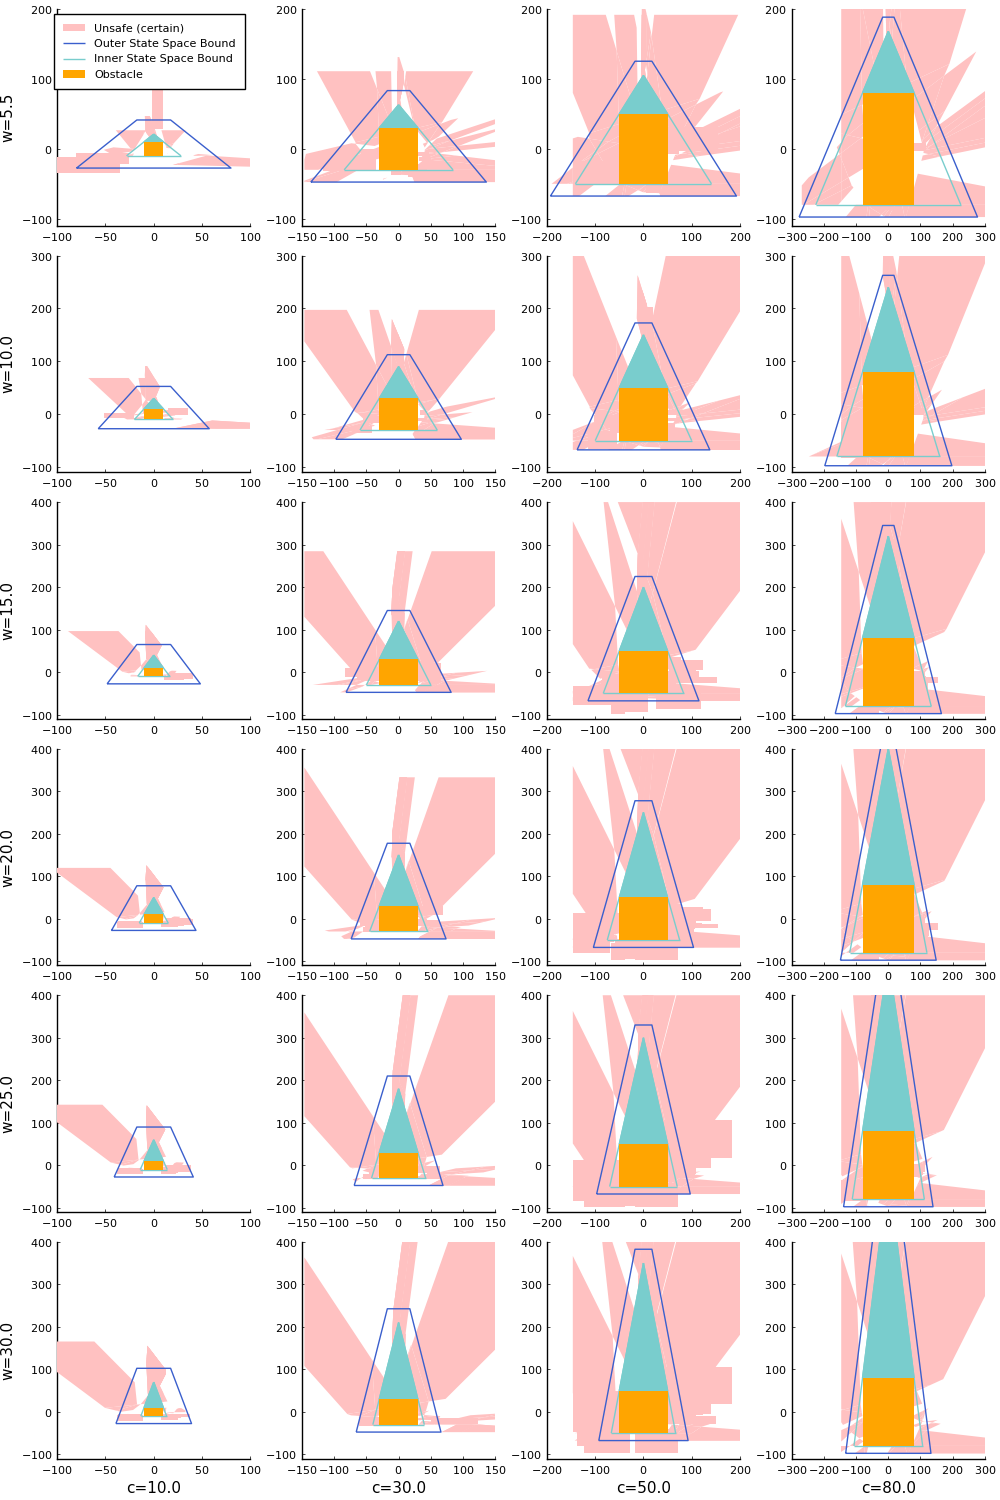

In [24]:
plots = []
legend_labels=false
unsafe_legend=false
unsafe_legend_to=false
in_legend = collect(false for star in filter(x->x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig_certain = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85902e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.99643e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.57144e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.96808e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.15025e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.18468e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.5922e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04262e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.35703e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.8987e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.7186e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.8914e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.85713e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: Lin

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.43524e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.80473e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.16147e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.85481e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

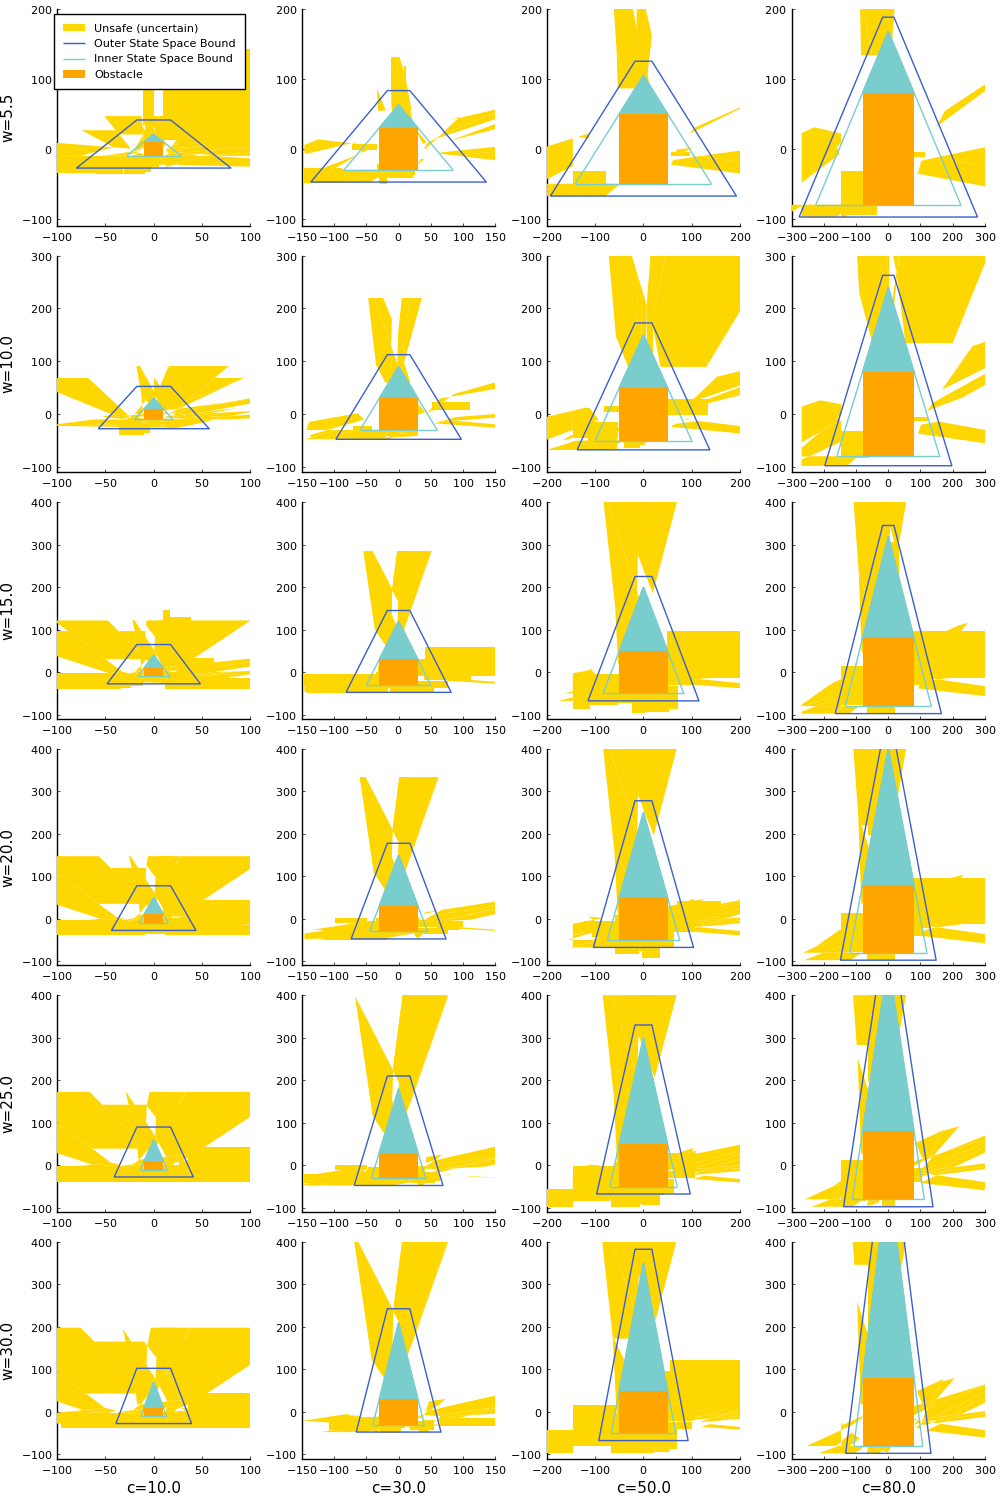

In [25]:
plots = []
legend_labels=false
unsafe_legend=false
unsafe_legend_to=false
in_legend = collect(false for star in filter(x->!x.certain,zeppelin_small2_stars))
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(filter(x->!x.certain,zeppelin_small2_stars),c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig_uncertain = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/polytope/solvers.py:139: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = optimize.linprog(
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85902e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.79122e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.58082e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.64854e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.24868e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.28694e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.45136e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.87742e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.04038e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.21412e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.14496e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.55462e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.18468e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.8846e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.05038e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.54396e-55): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.3113e-44): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: Li

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.77531e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.21981e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.90672e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.95881e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: 

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.01435e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.1167e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.28151e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.04953e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: L

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++---------------------------------------------------------------------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++----------------------------------------------------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-------------------

, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.10584e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.87018e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.172e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.47547e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/steuber/.julia/conda/3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: Li

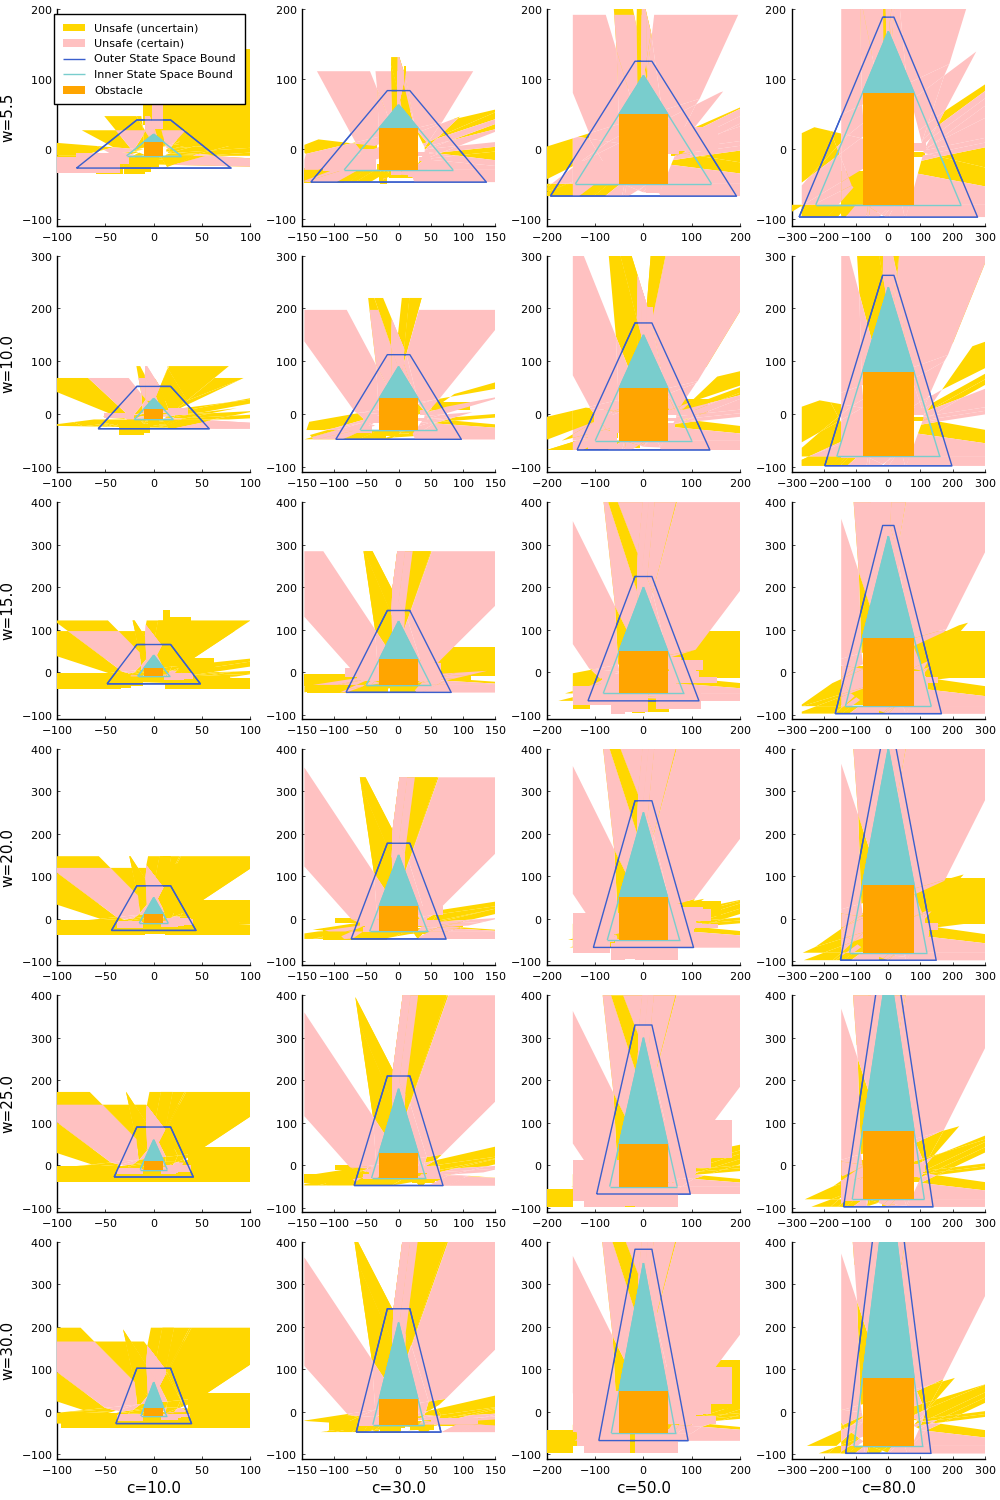

In [32]:
plots = []
first_round=true
legend_labels=true
unsafe_legend=false
unsafe_legend_to=false
in_legend = collect(false for star in zeppelin_small2_stars)
#print(length(in_legend))
c_vals = [5.5,10.0,15.0,20.0,25.0,30.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([10.0, 30.0,50.0, 80.0],[(-100,100),(-150,150),(-200,200),(-300,300)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        plot_all_zeppelin(filter(x->!x.certain,zeppelin_small2_stars),c,w)
        if first_round
            legend_labels=false
            first_round=false
        end
        push!(plots,plot_all_zeppelin(filter(x->x.certain,zeppelin_small2_stars),c,w;plotnew=false))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig_overall = plot(plots...,grid=false,layout=(6,4),size = (1000, 1500),link=:both,left_margin = [0Plots.mm 0Plots.mm])

In [33]:
savefig(fig_certain,"zeppelin-small2-certain.eps")
savefig(fig_uncertain,"zeppelin-small2-uncertain.eps")
savefig(fig_overall,"zeppelin-small2-all.eps")